# Исследование недвижимости


#### Цель исследования 
1. Определить рыночную стоимость объектов недвижимости
2. Установить параметры, влияющие на ценообразование
3. Построить автоматизированную систему, отслеживающую аномалии и мошенническую деятельность

#### Задачи 
1. Загрузить данные для работы
2. Выполнить предобработку данных
3. Рассчитать и добавить необходимые данные
4. Установить и обработать аномалии
5. Изучить время продажи квартир
6. Составить зависимости цены от различных факторов
7. Вычислить средние стоимости квартир по разным населенным пунктам
8. Рассчитать зависимость удаленности от центра и цены
9. Сделать выводы

In [267]:
import pandas as pd
import matplotlib.pyplot as plt

In [268]:
try:
    data = pd.read_csv('datasets/real_estate_data.csv',sep='\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')

In [269]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

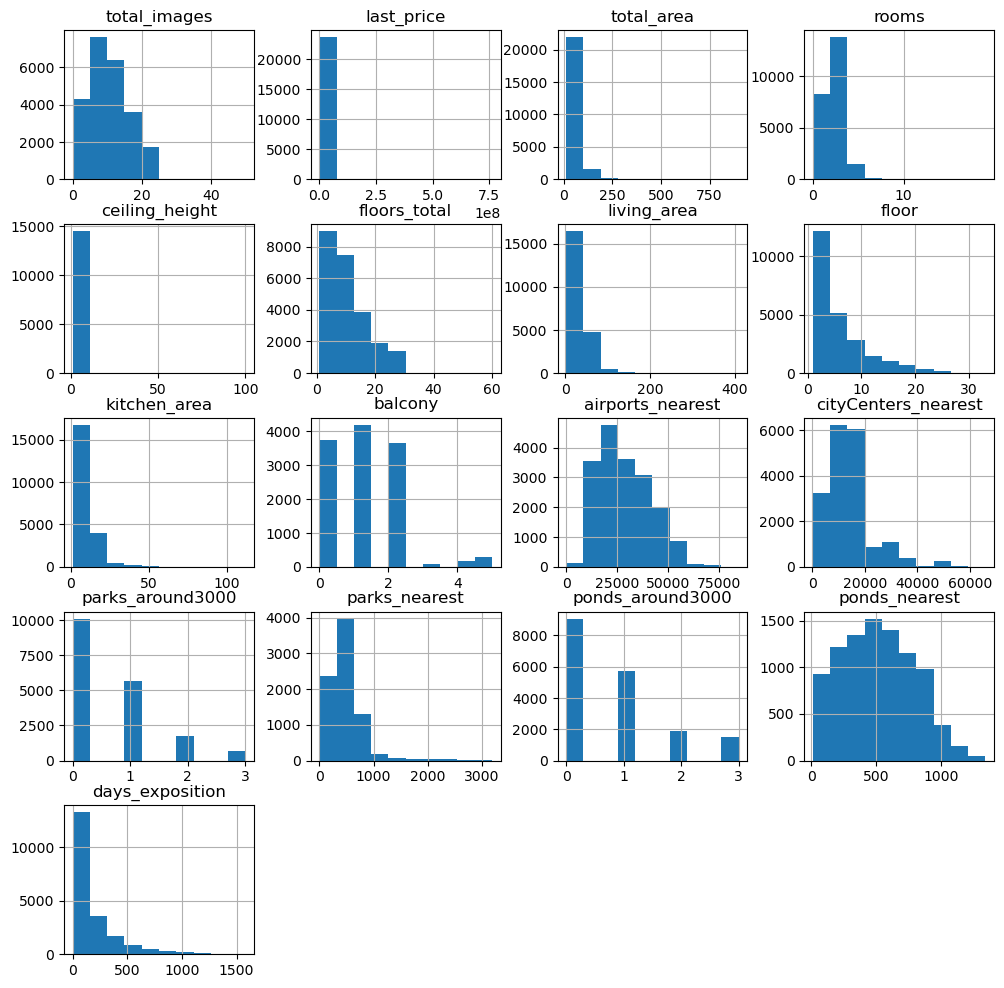

In [270]:
data.hist(figsize=(12,12));

### Предобработка

#### Работа с пропусками значений

In [271]:
#data.isna().sum()
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Возможные причины появления пропусков по столбцам:
- ceiling_height - высота потолков нулевой быть не может, оставим пропуски, так как медианное значение на таком количестве данных может исказить исследование
- floors_total - если речь о доме в пригороде, скорее всего этажей в нем 1, заменим на 1
- living_area - квартир с нулевой площадью быть не может, поэтому заменить значением 0 не сможем, оставим пропуски
- is_apartment - заменим на значение False, скорее всего отсутствующие значения говорят о том, что продаются не апартаменты
- kitchen_area - если речь идет о студии, вероятно площадь кухни не указывается, заменим на 0
- balcony - балконов нет, заменяем на 0
- locality_name - оставим пропуски, заменим их на None строкового типа
- airports_nearest - аэропоротов рядом нет, заменим на 0
- cityCenters_nearest - недвижимость находится в центре населенного пункта, заменим на 0
- parks_around3000 - нет парков в радиусе 3000, заменим на 0
- parks_nearest - на 0 заменить не можем, иначе половина объектов будут находится в парке
- ponds_nearest3000 - нет водоемов в радиусе 3000, заменим на 0
- ponds_nearest - на 0 заменить не можем, иначе половина объектов будут находиться на водоеме
- days_exposition - объявление выставлено в этот же день, можем заменить на 0

In [272]:
data['floors_total'] = data['floors_total'].fillna(1)
data['is_apartment'] = data['is_apartment'].fillna('False')
data['kitchen_area'] = data['kitchen_area'].fillna(0)
data['balcony'] = data['balcony'].fillna(0)
data['airports_nearest'] = data['airports_nearest'].fillna(0)
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['days_exposition'] = data['days_exposition'].fillna(0)
data['locality_name'] = data['locality_name'].fillna('None')

In [273]:
#print(data.isna().sum())
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,0.000000


Все пропуски, которые возможно было заменить данными, заполнены. Остались пропуски, которые нельзя заполнить медианными или заданными значениями

#### Работа с типами данных

In [274]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Необходимые замены типов данных:
- first_day_exposition - datetime, так как в столбце указаны даты
- floors_total - int, так как число этажей всегда целое
- is_apartment - bool, по условию булев тип
- balcony - int, так как количество этажей всегда целое число
- parks_around3000 - int, количество парков задается целым числом
- ponds_around3000 - int, количество водоемов задается целым числом
- days_exposition - int, количество дней задается целым числом

In [275]:
data['is_apartment'] = data['is_apartment'].astype('bool')
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
data['floor'] = data['floor'].astype('int')

In [276]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [277]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int32         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

Типы данных заменены

#### Работа с дубликатами

In [278]:
print(len(data['locality_name'].unique()))
print(data['locality_name'].unique())

365
['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый

Найдено 365 уникальных значений
В названиях существуют дубликаты, отличающиеся буквой "ё". Заменим на "е" во всех строках. Также дубликаты это: поселок - поселок городского типа, поселок - поселок при станции, поселок - поселок при железнодорожной станции, садовое некоммерческое товарищество - садовое товарищество.

In [279]:
data['new_locality_name'] = data['locality_name']
data['new_locality_name'] = (data['new_locality_name']
    .str.replace('ё','е')
    .replace(['поселок при железнодорожной станции','поселок станции','поселок городского типа', 'поселок при станции',
              'городской поселок', 'коттеджный поселок'], 'поселок', regex=True)
                            )
data['new_locality_name'] = data['new_locality_name'].str.replace('садоводческое некоммерческое товарищество','садовое товарищество')
print(len(data['new_locality_name'].unique()))
print(data['new_locality_name'].unique())
#pd.options.mode.chained_assignment = None

319
['Санкт-Петербург' 'поселок Шушары' 'поселок Янино-1' 'поселок Парголово'
 'поселок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'деревня Кудрово' 'Коммунар' 'Колпино' 'поселок Красный Бор' 'Гатчина'
 'деревня Федоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'поселок Металлострой' 'поселок Лебяжье'
 'поселок Сиверский' 'поселок Молодцово' 'поселок Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'поселок Аннино' 'поселок Ефимовский'
 'поселок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'поселок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'поселок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'деревня Оржицы' 'деревня Кальтино'
 'Кудрово' 'поселок Романовка' 'поселок Бугры' 'поселок Рощино' 'Кириши'
 'Луга' 'Волос

Дубликаты в названиях населенных пунктов удалены, уникальных названий населенных пунктов теперь - 319

#### Работа с аномалиями

В задании к проекту пункт с обработкой аномалий относится к 4 заданию, в блокноте по порядку задач работа с аномалиями проходит на данном этапе.
Рассмотрим все аномальные значения и обработаем те, о которых пойдет речь в следующих заданиях

In [280]:
data.duplicated().sum()

0

       total_images    last_price    total_area  \
count  23699.000000  2.369900e+04  23699.000000   
mean       9.858475  6.541549e+06     60.348651   
min        0.000000  1.219000e+04     12.000000   
25%        6.000000  3.400000e+06     40.000000   
50%        9.000000  4.650000e+06     52.000000   
75%       14.000000  6.800000e+06     69.900000   
max       50.000000  7.630000e+08    900.000000   
std        5.682529  1.088701e+07     35.654083   

                first_day_exposition         rooms  ceiling_height  \
count                          23699  23699.000000    14504.000000   
mean   2017-11-08 21:55:18.975484160      2.070636        2.771499   
min              2014-11-27 00:00:00      0.000000        1.000000   
25%              2017-05-12 12:00:00      1.000000        2.520000   
50%              2017-12-12 00:00:00      2.000000        2.650000   
75%              2018-08-26 00:00:00      3.000000        2.800000   
max              2019-05-03 00:00:00     19.000000

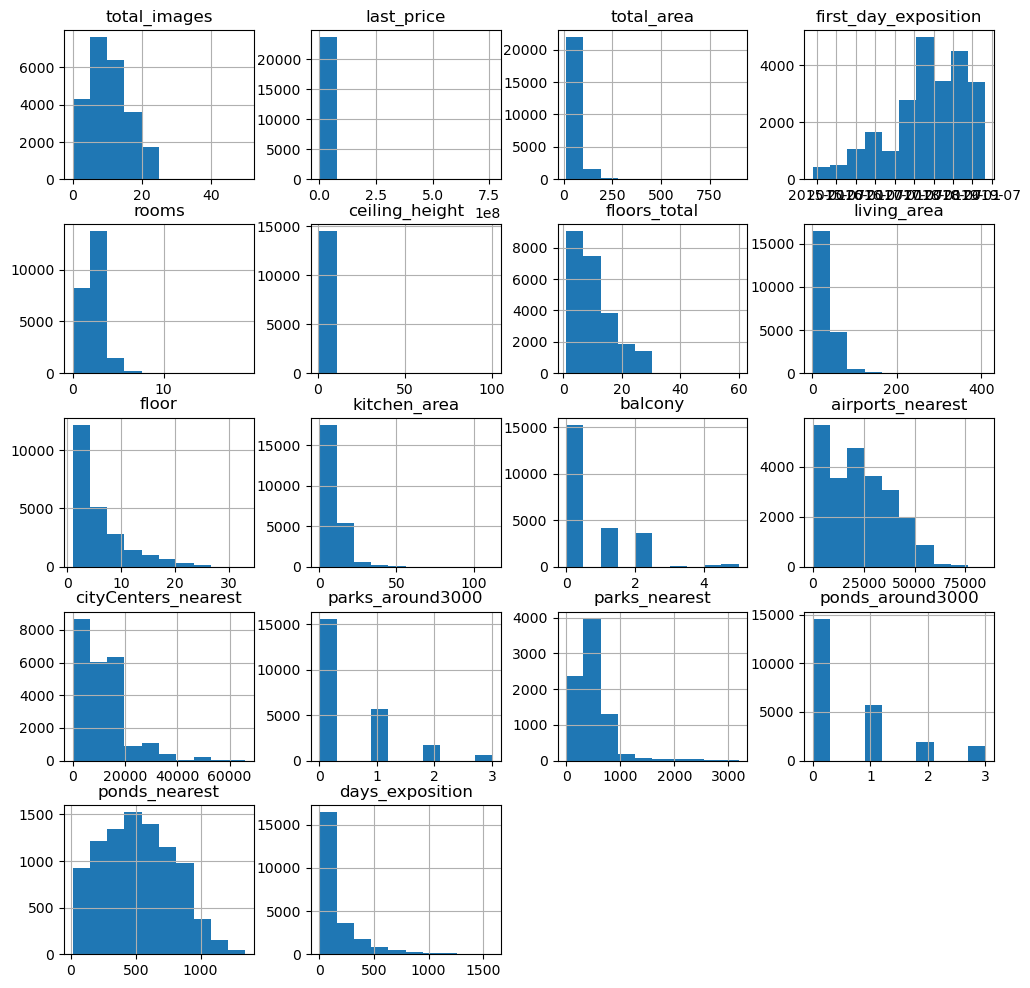

In [281]:
print(data.describe())
print(data.hist(figsize=(12,12)))

В некоторых столбцах явно видны аномалии:
- last_price - максимальное значение в 100 раз отличается от Q3, такие хоромы лучше убрать из набора данных, они будут сильно искажать среднее значение, по гистограмме видно, что большее количество значений цены находится в диапазоне до 9*10^6
- total_area - максимальное значение 900 выглядит аномально, при Q3 в 12 раз меньшем, отсечем до 200
- rooms - максимальное значение в 19 комнат сильно выделяется на фоне Q3 в 3 комнаты
- ceiling_height - высота потолков 100 выглядит как ошибка
- living_area - площадь 409 выглядит как ошибка на фоне средних 34
- kitchen_area - площадь кухни в 112 выбивается из средних 9

count    2.320600e+04
mean     5.579943e+06
std      3.593902e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.550000e+06
max      2.490000e+07
Name: last_price, dtype: float64
Axes(0.125,0.11;0.775x0.77)


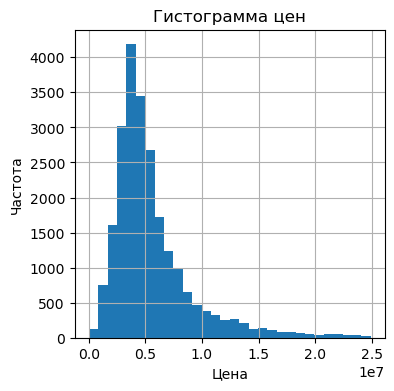

In [287]:
data = data[data['last_price']<2.5*10**7]
#print(data['last_price'].value_counts().sort_index())
print(data['last_price'].describe())
print(data['last_price'].hist(bins = 30,figsize=(4,4)))
plt.title('Гистограмма цен')
plt.ylabel('Частота')
plt.xlabel('Цена')
plt.show()

Теперь по гистограмме цен заметно, что с увеличением цен, количество предложений уменьшается. Также заметно малое количество низких цен, что можно объяснить предложениями недвижимости из деревень и сёл.

Удалив аномальные цены, проверим, может быть аномалии в других столбцах находились в удаленных строках

Axes(0.125,0.11;0.775x0.77)


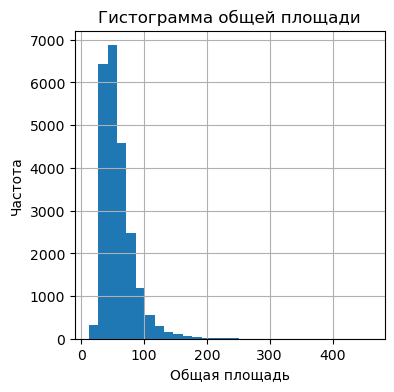

In [290]:
#print(data['total_area'].value_counts().sort_index().tail(20))
print(data['total_area'].hist(bins=30, figsize=(4,4)))
plt.title('Гистограмма общей площади')
plt.ylabel('Частота')
plt.xlabel('Общая площадь')
plt.show()

График действительно изменился, отбросим все значения, большие 150, но например, заменять знечение 200 на 20.0 не имеет смысла, так как квартиры такой площади могут существовать

count    22927.000000
mean        55.973368
std         22.131867
min         12.000000
25%         40.000000
50%         51.000000
75%         67.000000
max        149.600000
Name: total_area, dtype: float64
Axes(0.125,0.11;0.775x0.77)


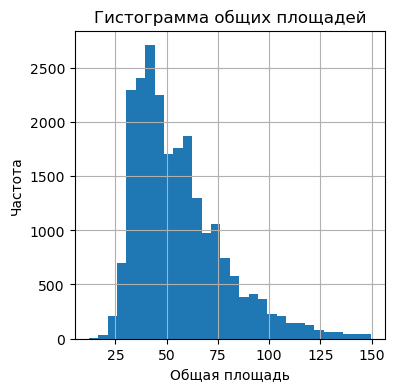

In [292]:
data = data[data['total_area'] < 150]
#print(data['total_area'].value_counts().sort_index().tail(20))
print(data['total_area'].describe())
print(data['total_area'].hist(bins=30,figsize=(4,4)))
plt.title('Гистограмма общих площадей')
plt.ylabel('Частота')
plt.xlabel('Общая площадь')
plt.show()

Количество недвижимости большой площади значительно меньше, чем недвижимости , площадью до 70 кв.м. Есть площади, меньше, чем 25 кв.м., но удалять их как аномалии не будем, так как это отдельный тип квартир - студии.

Проверим следующее распределение количества комнат в квартире

rooms
0     196
1    8038
2    7896
3    5615
4     980
5     172
6      23
7       7
Name: count, dtype: int64
Axes(0.125,0.11;0.775x0.77)


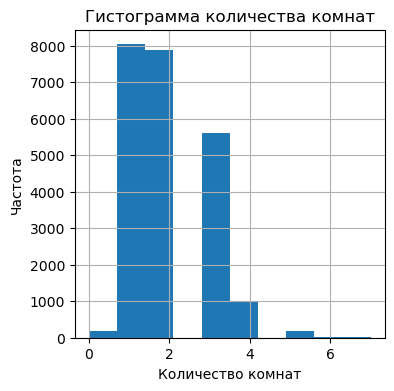

In [294]:
print(data['rooms'].value_counts().sort_index())
print(data['rooms'].hist(figsize=(4,4)))
plt.title('Гистограмма количества комнат')
plt.ylabel('Частота')
plt.xlabel('Количество комнат')
plt.show()

Оставим всё как есть, так как хвост распределения значительно уменьшился после предыдущих операций. Рассмотрим высоту потолков

count    13981.000000
mean         2.754701
std          1.278626
min          1.000000
25%          2.500000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64
Axes(0.125,0.11;0.775x0.77)


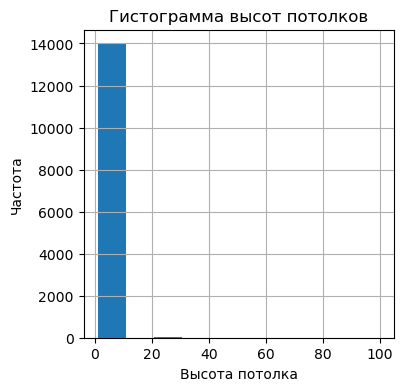

In [296]:
#print(data['ceiling_height'].value_counts().sort_index().tail(20))
print(data['ceiling_height'].describe())
print(data['ceiling_height'].hist(figsize=(4,4)))
plt.title('Гистограмма высот потолков')
plt.ylabel('Частота')
plt.xlabel('Высота потолка')
plt.show()

Заменим пропуски в высотах потолка медианными значениями, в зависимости от этажности дома

In [297]:
data.loc[data['ceiling_height'] >= 25, 'ceiling_height'] = data['ceiling_height'] / 10
for total_floor in data['floors_total'].unique():
    height_median = data.loc[data['floors_total']==total_floor,'ceiling_height'].median()
    data.loc[(data['floors_total']==total_floor)&(data['ceiling_height'].isna()),'ceiling_height'] = height_median
#print(data.isna().sum())

Аномальные значения остались, отсечем все строки, где высота потолков выше или равна 8м, уменьшим все значения, большие 25, в 10 раз. Также есть очень небольшие значения высоты, удалим все строки, со значениями менее 2.3 м

count    22896.000000
mean         2.694091
std          0.212255
min          2.340000
25%          2.550000
50%          2.650000
75%          2.750000
max          5.800000
Name: ceiling_height, dtype: float64
Axes(0.125,0.11;0.775x0.77)
0


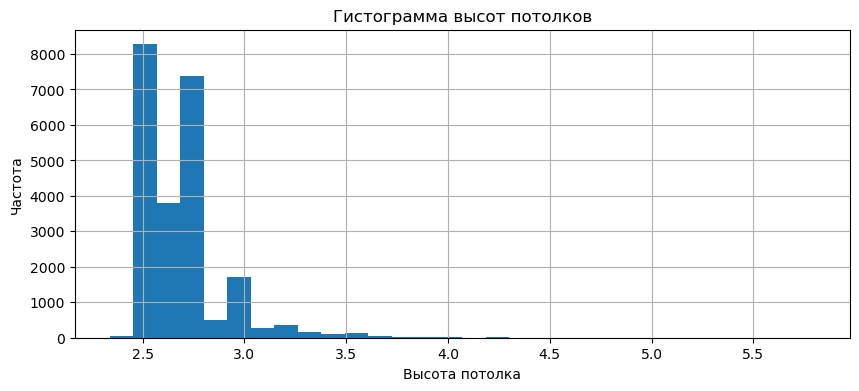

In [299]:
#print(data['ceiling_height'].value_counts().sort_index())
data = data[(data['ceiling_height']>2.3)&(data['ceiling_height']<8)]
print(data['ceiling_height'].describe())
print(data['ceiling_height'].hist(bins=30,figsize=(10,4)))
#print(data['ceiling_height'].unique())
print(data['ceiling_height'].isna().sum())
plt.title('Гистограмма высот потолков')
plt.ylabel('Частота')
plt.xlabel('Высота потолка')
plt.show()

Остались значения высот потолка, которые выглядят наиболее реалистичными, больше всего значений в диапазоне от 2.3 до 2.8

Рассмотрим распределение жилой площади

count    21083.000000
mean        32.035730
std         15.037573
min          2.000000
25%         18.500000
50%         30.000000
75%         41.000000
max        128.000000
Name: living_area, dtype: float64
Axes(0.125,0.11;0.775x0.77)


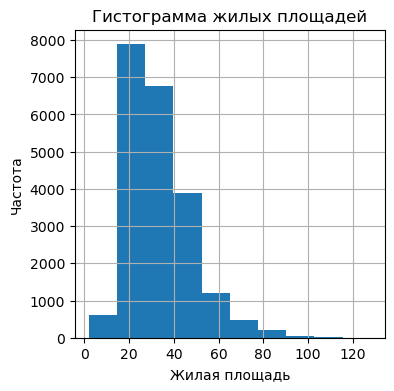

In [301]:
print(data['living_area'].describe())
print(data['living_area'].hist(figsize=(4,4)))
plt.title('Гистограмма жилых площадей')
plt.ylabel('Частота')
plt.xlabel('Жилая площадь')
plt.show()

После проведения предыдущих этапов обработки, на гистограмме видно, что хвост уменьшился. Оставим столбец без изменений. Далее посмотрим на площадь кухни

count    22896.000000
mean         9.129865
std          5.351109
min          0.000000
25%          6.300000
50%          8.700000
75%         11.000000
max         64.000000
Name: kitchen_area, dtype: float64
Axes(0.125,0.11;0.775x0.77)


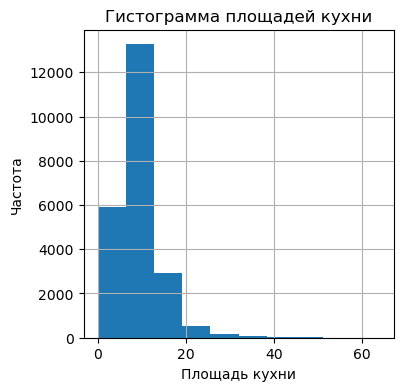

In [302]:
print(data['kitchen_area'].describe())
print(data['kitchen_area'].hist(figsize=(4,4)))
#print(data['kitchen_area'].value_counts().sort_index().tail(30))
plt.title('Гистограмма площадей кухни')
plt.ylabel('Частота')
plt.xlabel('Площадь кухни')
plt.show()

Отбросим площади, большие 25, так как остальные - редко встречающиеся значения. Значения 0 оставим, так как в случае квартир-студий возможно отсутствие кухни

count    22578.000000
mean         8.789807
std          4.471782
min          0.000000
25%          6.300000
50%          8.600000
75%         11.000000
max         25.000000
Name: kitchen_area, dtype: float64
Axes(0.125,0.11;0.775x0.77)


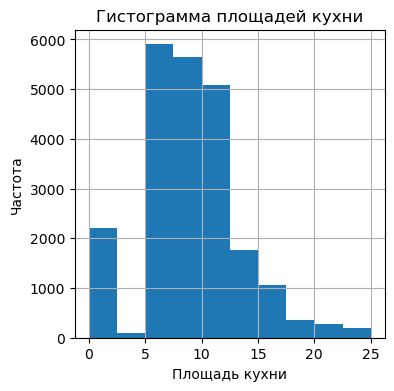

In [303]:
data = data[data['kitchen_area'] <= 25]
#print(data['kitchen_area'].value_counts().sort_index().tail(20))
print(data['kitchen_area'].describe())
print(data['kitchen_area'].hist(figsize=(4,4)))
plt.title('Гистограмма площадей кухни')
plt.ylabel('Частота')
plt.xlabel('Площадь кухни')
plt.show()

Снова посмотрим на обновленную таблицу

       total_images    last_price    total_area  \
count  22578.000000  2.257800e+04  22578.000000   
mean       9.754185  5.332857e+06     55.416435   
min        0.000000  4.300000e+05     12.000000   
25%        6.000000  3.390000e+06     39.500000   
50%        9.000000  4.500000e+06     50.500000   
75%       14.000000  6.361363e+06     66.100000   
max       50.000000  2.490000e+07    149.600000   
std        5.605569  3.184451e+06     21.571865   

                first_day_exposition         rooms  ceiling_height  \
count                          22578  22578.000000    22578.000000   
mean   2017-11-13 08:29:31.777837056      1.982594        2.691445   
min              2014-11-27 00:00:00      0.000000        2.340000   
25%              2017-05-18 00:00:00      1.000000        2.550000   
50%              2017-12-14 00:00:00      2.000000        2.650000   
75%              2018-08-28 00:00:00      3.000000        2.750000   
max              2019-05-03 00:00:00      7.000000

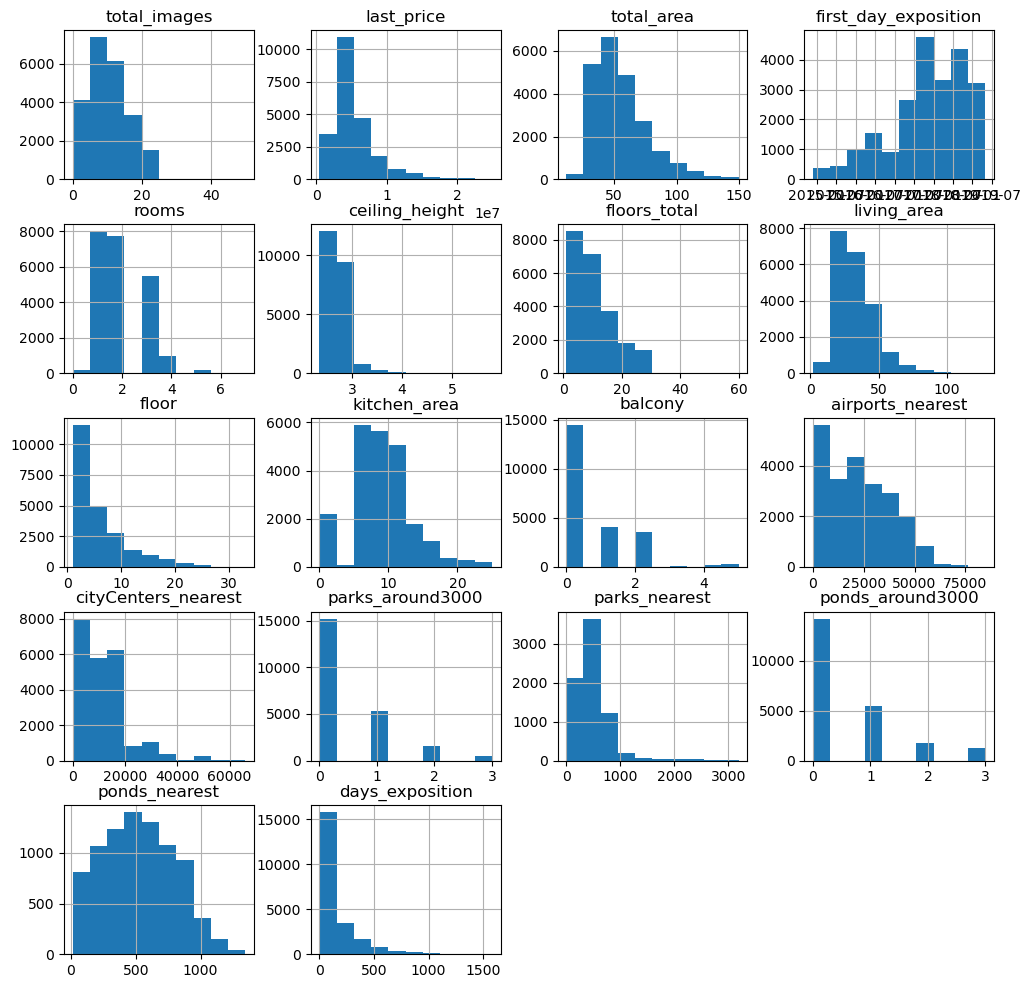

In [304]:
print(data.describe())
print(data.hist(figsize=(12,12)));

In [305]:
data = data.reset_index(drop=True)

Теперь распределения стали не настолько смещенными влево, аномально большие значения отсутсвуют, необычно маленьке - объяснены. Индексы обновлены

На этапе предобработки данных были выполнены следующие действия:
- заполнены пропуски
- заменены типы данных
- заменены неявные дубликаты
- рассмотрены столбцы с аномальными значениями

В исходных данных было большое количество пропусков в следующих столбцах:
ceiling_height	39%,
is_apartment	88%,
balcony	49%,
parks_nearest	66%,
ponds_nearest	62%.
Также в таблице содержались неявные дубликаты, которые появились вследствие разной записи одних населенных пунктов

Цена одного квадратного метра - стоимость/площадь

In [306]:
data['price_meter'] = data['last_price']/data['total_area']

День, месяц и год публикации объявления

In [307]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

Тип этажа

In [308]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floors_total'] == row['floor']:
        return 'последний'
    else:
        return 'другой'

data['floor_type'] = data.apply(floor_type,axis=1)
print(data['floor_type'].unique())

['другой' 'первый' 'последний']


Расстояние до центра города в километрах

In [309]:
data['cityCenter_km'] = data['cityCenters_nearest']/1000
data['cityCenter_km'] = data['cityCenter_km'].apply(round)

In [310]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22578 entries, 0 to 22577
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22578 non-null  int64         
 1   last_price            22578 non-null  float64       
 2   total_area            22578 non-null  float64       
 3   first_day_exposition  22578 non-null  datetime64[ns]
 4   rooms                 22578 non-null  int64         
 5   ceiling_height        22578 non-null  float64       
 6   floors_total          22578 non-null  int32         
 7   living_area           20782 non-null  float64       
 8   floor                 22578 non-null  int32         
 9   is_apartment          22578 non-null  bool          
 10  studio                22578 non-null  bool          
 11  open_plan             22578 non-null  bool          
 12  kitchen_area          22578 non-null  float64       
 13  balcony         

In [311]:
print(data.head(10))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00           2019-03-07      3   
1             7   3350000.0       40.40           2018-12-04      1   
2            10   5196000.0       56.00           2015-08-20      2   
3            10   2890000.0       30.40           2018-09-10      1   
4             6   3700000.0       37.30           2017-11-02      1   
5             5   7915000.0       71.60           2019-04-18      2   
6            20   2900000.0       33.16           2018-05-23      1   
7            18   5400000.0       61.00           2017-02-26      3   
8             5   5050000.0       39.60           2017-11-16      1   
9             9   3300000.0       44.00           2018-08-27      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16        51.00      8          True  ...   
1            2.75            11        18.60      1          True  ...

В таблицу добавлены новые столбцы

### Исследовательский анализ данных

Некоторые параметры были подробно рассмотрены ранее:
- общая площадь - описано в пункте - работа с аномалиями
- жилая площадь - описано в пункте - работа с аномалиями
- площадь кухни - описано в пункте - работа с аномалиями
- цена объекта - описано в пункте - работа с аномалиями
- количество комнат - описано в пункте - работа с аномалиями
- высота потолков - описано в пункте - работа с аномалиями

Остаются:
- тип этажа квартиры
- общее количество этажей в доме
- расстояние до центра города в метрах
- расстояние до ближайшего парка

Тип этажа квартиры

floor_type
другой       16622
последний     3109
первый        2847
Name: count, dtype: int64
Axes(0.125,0.11;0.775x0.77)


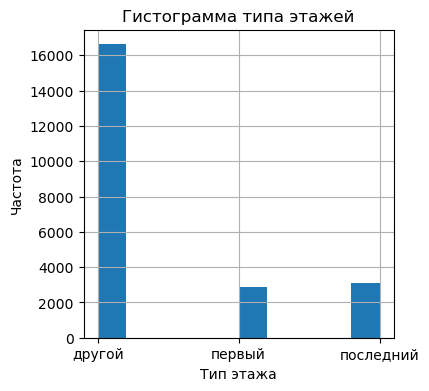

In [313]:
print(data['floor_type'].value_counts())
print(data['floor_type'].hist(figsize=(4,4)))
plt.title('Гистограмма типа этажей')
plt.ylabel('Частота')
plt.xlabel('Тип этажа')
plt.show()

Большинство предложений недвижимости - на промежуточных этажах. Предложений на первом этаже меньше , чем предложений на последнем.

Оценим, как распределяются объявления в зависимости от высоты дома

count    22578.000000
mean        10.725042
std          6.645188
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64
Axes(0.125,0.11;0.775x0.77)


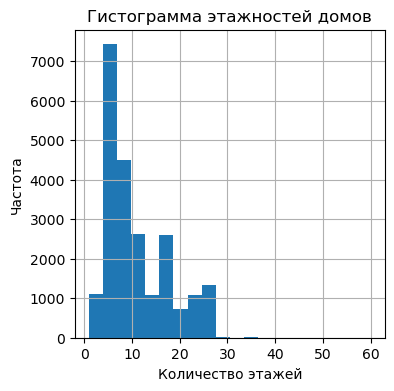

In [315]:
print(data['floors_total'].describe())
print(data['floors_total'].hist(bins=20, figsize=(4,4)))
plt.title('Гистограмма этажностей домов')
plt.ylabel('Частота')
plt.xlabel('Количество этажей')
plt.show()

Отбросим редкие значения, большие 28, так как небоскребов в этом наборе данных очень мало

count    22578.000000
mean        10.725042
std          6.645188
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64
Axes(0.125,0.11;0.775x0.77)


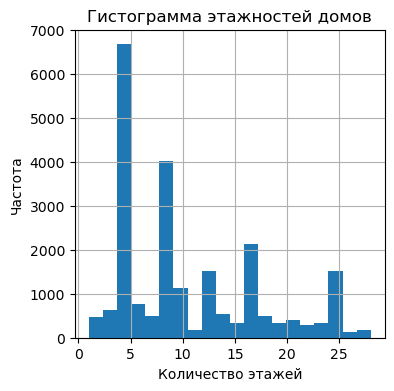

In [317]:
print(data['floors_total'].describe())
print(data['floors_total'].hist(bins=20, figsize=(4,4), range=(1,28)))
plt.title('Гистограмма этажностей домов')
plt.ylabel('Частота')
plt.xlabel('Количество этажей')
plt.show()

Больше всего среди предложений в домах с 5 и 9 этажами. Также прослеживается зависимость - чем выше дом, тем меньше предложений, скорее всего высоких домов построено меньше, чем пяти- и девятиэтажек

Посмотрим на удаленность от центра

count    22578.000000
mean     11049.665294
std       9713.069645
min          0.000000
25%       1780.000000
50%      11537.000000
75%      15420.750000
max      65968.000000
Name: cityCenters_nearest, dtype: float64
Axes(0.125,0.11;0.775x0.77)


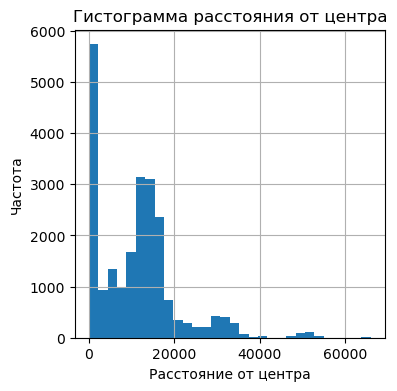

In [318]:
print(data['cityCenters_nearest'].describe())
print(data['cityCenters_nearest'].hist(bins=30, figsize=(4,4)))
plt.title('Гистограмма расстояния от центра')
plt.ylabel('Частота')
plt.xlabel('Расстояние от центра')
plt.show()

Расстояния до центра, большие 40 км, похожи на ошибку, так как скорее всего было добавлено расстояние до центра Санкт-Петербурга из других населенных пунктов, вместо расстояния до центра именно этого населенного пункта. Также есть подозрительный пик в области 0, на основе которого можно сделать вывод, что есть много предложений о продаже недвижимости в центре города.

count    22283.000000
mean     10530.979132
std       8647.568282
min          0.000000
25%       1313.000000
50%      11393.000000
75%      15206.000000
max      39936.000000
Name: cityCenters_nearest, dtype: float64
Axes(0.125,0.11;0.775x0.77)


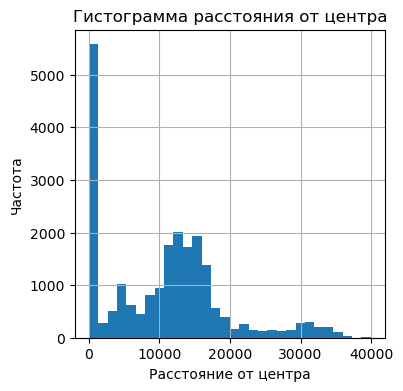

In [320]:
for city in data['new_locality_name'].unique():
    dist_median = data.loc[data['new_locality_name']==city,'cityCenters_nearest'].median()
    data.loc[(data['new_locality_name']==city)&(data['cityCenters_nearest'].isna()),'cityCenters_nearest'] = dist_median

data = data[data['cityCenters_nearest'] < 40000]
print(data['cityCenters_nearest'].describe())
print(data['cityCenters_nearest'].hist(bins=30, figsize=(4,4)))
plt.title('Гистограмма расстояния от центра')
plt.ylabel('Частота')
plt.xlabel('Расстояние от центра')
plt.show()

Теперь пик в 0 еще более заметен. Оставим его, так как в малых населенных пунктах многие дома могут считаться центром. Посмотрим, так ли это

In [321]:
print(data[data['cityCenters_nearest']==0]['new_locality_name'])

3             поселок Янино-1
6              поселок Мурино
10                  Сертолово
20            деревня Кудрово
28                   Коммунар
                 ...         
22562    поселок Дзержинского
22571                  Тихвин
22574                   Тосно
22575        село Рождествено
22577     поселок Новый Учхоз
Name: new_locality_name, Length: 5454, dtype: object


Предположение подтвердилось - это дома из малых населенных пунктов

Рассмотрим ближайшие парки

count    7243.000000
mean      496.604584
std       340.193335
min         1.000000
25%       295.000000
50%       459.000000
75%       618.000000
max      3190.000000
Name: parks_nearest, dtype: float64
Axes(0.125,0.11;0.775x0.77)


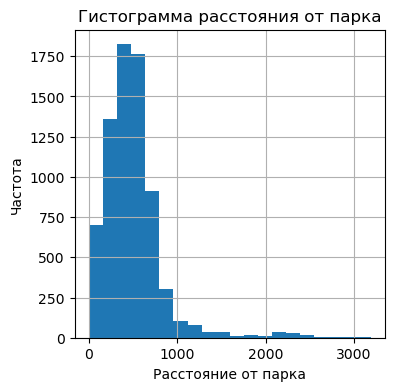

In [323]:
print(data['parks_nearest'].describe())
print(data['parks_nearest'].hist(bins=20,figsize=(4,4)))
plt.title('Гистограмма расстояния от парка')
plt.ylabel('Частота')
plt.xlabel('Расстояние от парка')
plt.show()

В основном, все предложения - недалеко от парков, основная масса - до 1000 м. Отбросим значения, большие 1500м, но удалять из данных не будем

count    7243.000000
mean      496.604584
std       340.193335
min         1.000000
25%       295.000000
50%       459.000000
75%       618.000000
max      3190.000000
Name: parks_nearest, dtype: float64
Axes(0.125,0.11;0.775x0.77)


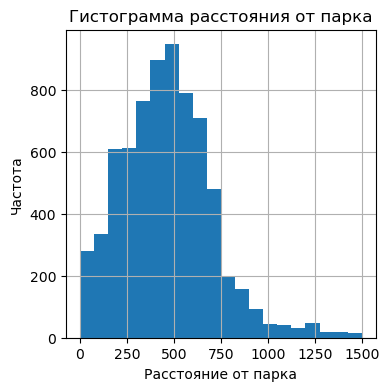

In [324]:
print(data['parks_nearest'].describe())
print(data['parks_nearest'].hist(bins=20, range=(0,1500), figsize=(4,4)))
plt.title('Гистограмма расстояния от парка')
plt.ylabel('Частота')
plt.xlabel('Расстояние от парка')
plt.show()

Предложений вдали от парков совсем немного, в большинстве случаев парк можно найти в радиусе 750м

Все необходимые параметры рассмотрены, аномалии удалены, ошибки исправлены

In [325]:
len(data)

22283

#### Как быстро продавались квартиры

Axes(0.125,0.11;0.775x0.77)
Медианное знаечение: 73.0
Среднее значение: 153.50657451869137


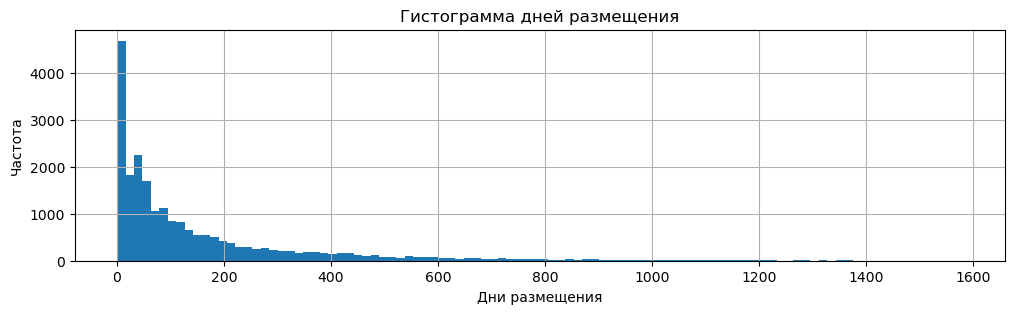

In [328]:
print(data['days_exposition'].hist(bins = 100, figsize=(12,3)))
print('Медианное знаечение:',data['days_exposition'].median())
print('Среднее значение:',data['days_exposition'].mean())
plt.title('Гистограмма дней размещения')
plt.ylabel('Частота')
plt.xlabel('Дни размещения')
plt.show()

Axes(0.125,0.11;0.775x0.77)


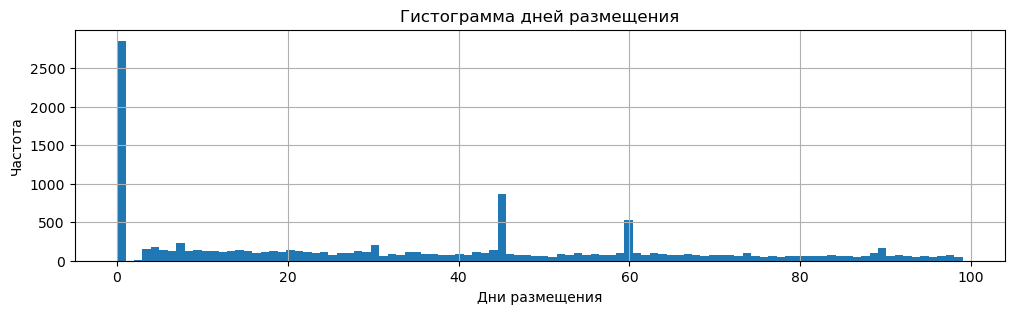

In [329]:
print(data[data['days_exposition']<100]['days_exposition'].hist(bins = 100, figsize=(12,3)))
plt.title('Гистограмма дней размещения')
plt.ylabel('Частота')
plt.xlabel('Дни размещения')
plt.show()

Многие объекты проданы в срок до 200 дней. Есть объекты, объявления с которыми были размещены более 1000 дней - около 3-5х лет. Возможно, эти объявления не убрали в срок. В любом случае такие объявления - аномальны.
Продажи в день размещения объявления - необычно быстрые.
Средний срок продажи - 156 дней, медианный - 71.

In [330]:
data['days_exposition'].describe()

count    22283.000000
mean       153.506575
std        208.628617
min          0.000000
25%         23.000000
50%         73.000000
75%        194.000000
max       1580.000000
Name: days_exposition, dtype: float64

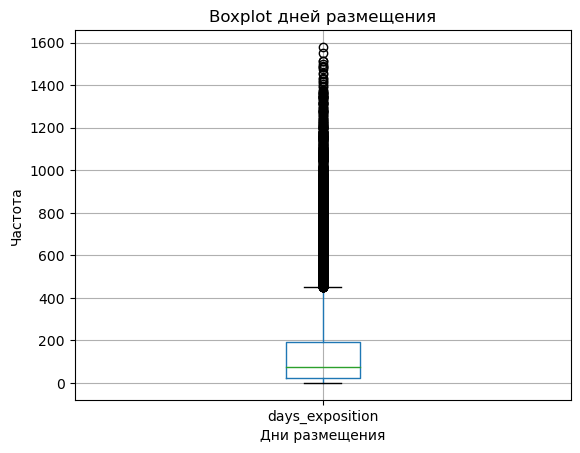

In [332]:
data.boxplot(column='days_exposition')
plt.title('Boxplot дней размещения')
plt.ylabel('Частота')
plt.xlabel('Дни размещения')
plt.show()

По описанию данных из столбца и графику заметим:
- выбросами считаем все значения, большие 450
- медианное значение находится в пределах 100 дней.
    
Быстрыми продажами будем считать продажи в срок до 23 дней, обычными от 23 до 194, долгими считаем все, что больше 194 дней. Про объявления, которые выложены более 450 дней скорее всего забыли

#### Определение факторов, которые влияют на стоимость объекта

0.7538860082547097


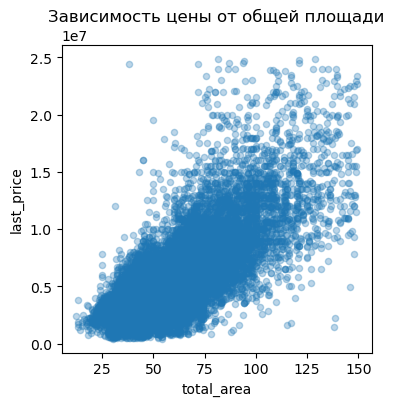

In [338]:
print(data['total_area'].corr(data['last_price']))
data.plot(x = 'total_area', y = 'last_price', kind='scatter', alpha=0.3, figsize = (4,4), title='Зависимость цены от общей площади');

Выше представлена зависимость цены от площади объекта. Коэффициент Пирсона и график показывают, что между параметрами есть сильная взаимосвязь

0.6469818118209331


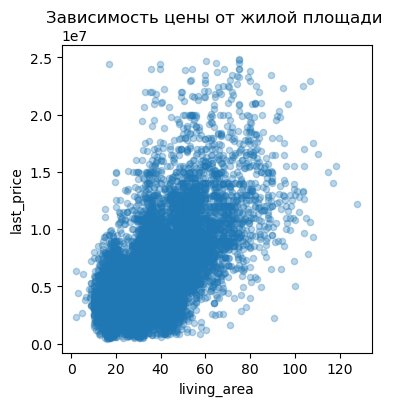

In [336]:
print(data['living_area'].corr(data['last_price']))
data.plot(x = 'living_area', y = 'last_price', kind='scatter', alpha=0.3, figsize = (4,4), title='Зависимость цены от жилой площади ');

Влияние жилой площади на цену слабее, чем влияние общей площади, тем не менее связь достаточно сильная

0.41673774719086226


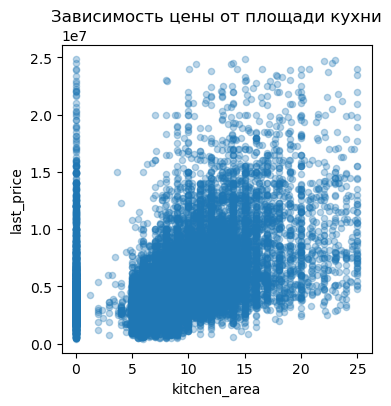

In [337]:
print(data['kitchen_area'].corr(data['last_price']))
data.plot(x = 'kitchen_area', y = 'last_price', kind='scatter', alpha=0.3, figsize = (4,4), title='Зависимость цены от площади кухни');

Зависимость достаточно слабая, судя по коэффициенту Пирсона. Из предыдущих шагов исследования мы выяснили, что нулевая площадь кухни часто встречается у квартир-студий, где площади кухонь нет. Если убрать из выборки студии, то связь более сильная

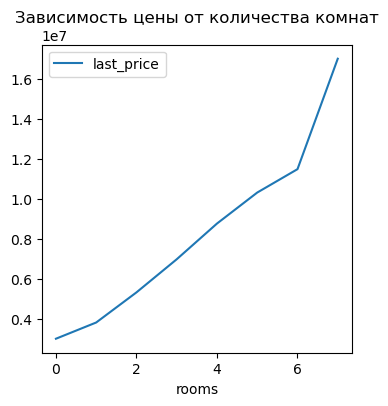

In [339]:
#print(data['rooms'].corr(data['last_price']))
#data.plot(x = 'rooms', y = 'last_price', kind='scatter', alpha=0.3, figsize = (4,4))

data.pivot_table(index='rooms', values='last_price').plot(figsize=(4,4), title='Зависимость цены от количества комнат');

С увеличением количества комнат, будет расти и общая площадь объекта, возможно здесь имеет место косвенная зависимость.

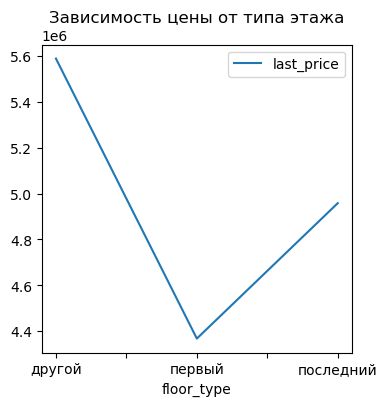

In [340]:
data.pivot_table(index='floor_type', values='last_price').plot(figsize=(4,4), title='Зависимость цены от типа этажа');

Между номером этажа и ценой есть связь, первые этажи более дешевые, по сравнению с последними

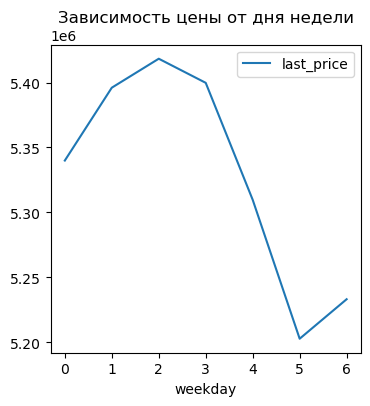

In [341]:
#data.plot(x = 'weekday', y = 'last_price', kind='scatter', alpha=0.3, figsize = (4,4))
data.pivot_table(index='weekday', values='last_price').plot(figsize=(4,4), title='Зависимость цены от дня недели');

По гистограмме заметно, что объекты, выложенные в выходные, более дешевые

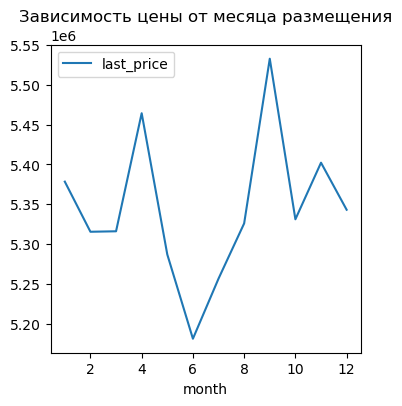

In [344]:
#data.plot(x = 'month', y = 'last_price', kind = 'scatter', alpha=0.3, figsize = (4,4))
data.pivot_table(index='month', values='last_price').plot(figsize=(4,4), title='Зависимость цены от месяца размещения');

По гистограмме видно небольшие колебания цены, в зависимости от месяца. Например, в мае и июне цены наиболее низкие, тогда как апрель и сентябрь показывают наиболее высокие цены

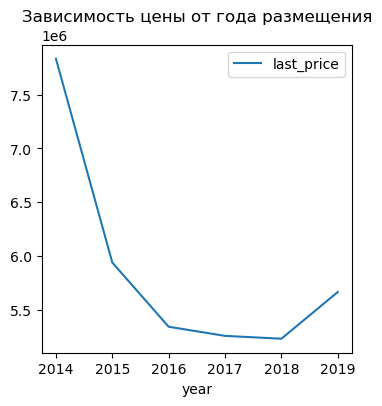

In [343]:
#data.plot(x = 'year', y = 'last_price', kind='scatter', alpha=0.3, figsize = (4,4))
data.pivot_table(index='year', values='last_price').plot(figsize=(4,4), title='Зависимость цены от года размещения');

Средняя стоимость к 2018 году уменьшалась, далее начинает возрастать. Такой график может не показывать реальность, так как в первые годы объявлений было мало

#### Средняя стоимость за квадратный метр

In [345]:
print(data['new_locality_name'].value_counts().head(10))
print(data['new_locality_name'].value_counts().tail(10))

new_locality_name
Санкт-Петербург      14706
поселок Мурино         554
поселок Шушары         438
Всеволожск             392
Пушкин                 349
Колпино                336
поселок Парголово      326
Гатчина                304
деревня Кудрово        296
Выборг                 230
Name: count, dtype: int64
new_locality_name
деревня Реброво         1
деревня Мануйлово       1
поселок Счастье         1
поселок Кондратьево     1
деревня Пчева           1
поселок Цвылево         1
деревня Курковицы       1
деревня Кривко          1
поселок Жилпоселок      1
поселок Дзержинского    1
Name: count, dtype: int64


In [346]:
#print(data.groupby('new_locality_name').agg({'price_meter' : ['mean']}))

In [347]:
top = data['new_locality_name'].value_counts().head(10).index

In [348]:
print(data.query('new_locality_name in @top').pivot_table(index='new_locality_name', values='last_price').sort_values(by='last_price', ascending=False))

                     last_price
new_locality_name              
Санкт-Петербург    6.343218e+06
Пушкин             5.700817e+06
поселок Парголово  4.477609e+06
деревня Кудрово    4.220863e+06
поселок Шушары     4.102868e+06
Колпино            3.862974e+06
Всеволожск         3.744258e+06
поселок Мурино     3.644698e+06
Гатчина            3.442169e+06
Выборг             3.150622e+06


Средняя стоимость на разном удалении от центра Санкт-Петербурга

    cityCenter_km         price
0               0  8.033805e+06
1               1  1.015844e+07
2               2  9.740106e+06
3               3  8.705774e+06
4               4  9.244010e+06
5               5  9.451896e+06
6               6  8.581595e+06
7               7  7.922530e+06
8               8  7.875050e+06
9               9  6.337273e+06
10             10  6.071174e+06
11             11  5.852412e+06
12             12  5.685697e+06
13             13  5.874910e+06
14             14  5.453416e+06
15             15  5.559819e+06
16             16  5.255343e+06
17             17  5.098266e+06
18             18  4.749535e+06
19             19  5.037675e+06
20             20  5.906846e+06
21             21  5.398298e+06
22             22  5.270343e+06
23             23  4.689843e+06
24             24  3.854430e+06
25             25  4.052840e+06
26             26  3.973013e+06
27             27  8.300000e+06
28             28  5.026429e+06
29             29  4.236667e+06


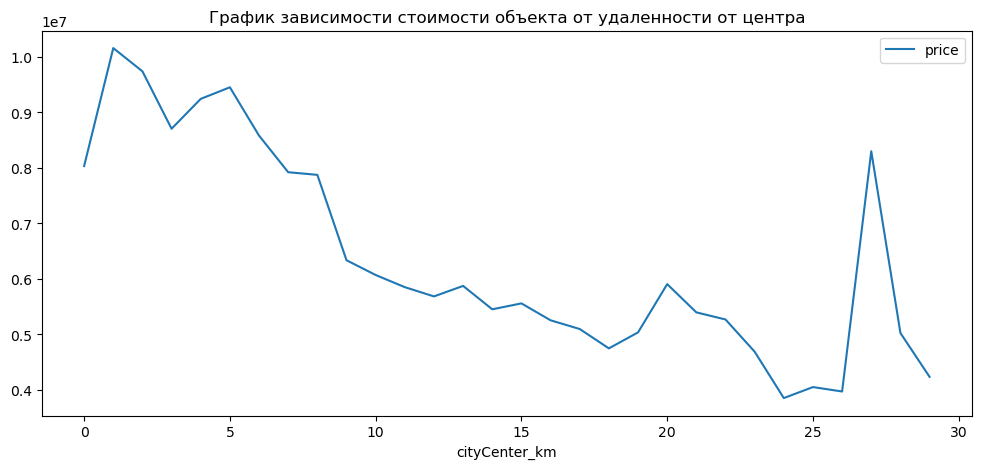

In [349]:
mean_km = data[data['locality_name'] == 'Санкт-Петербург'].groupby('cityCenter_km', as_index=False).agg({'last_price':['mean']})
mean_km.columns = ['cityCenter_km', 'price']
print(mean_km)
mean_km.plot('cityCenter_km', 'price', figsize=(12,5), title = 'График зависимости стоимости объекта от удаленности от центра');

По результатам анализа видим, что с увеличением расстояния от центра цена уменьшается, но при достижении расстояния в 20-25 км снова начинает увеличиваться. Возможно, связано это с тем, что на таком расстоянии от центра появляются более просторные объекты.

В результате проведенного анализа данных отследили влияние некоторых параметров на цену объекта. Сильнее всего влияет площадь объекта, также имеет влияние этаж, на котором расположен объект. При увеличении расстояния ожидаемо падает цена, но на большом расстоянии есть скачки стоимости

### Общий вывод

Перед началом выполнения исследовательского анализа данных данные были изучены методом info(), с помощью которого рассмотрены типы данных, и при помощи гистограмм, которые показали распределение значений по каждому столбцу. 
Следующим шагом были заполнены пропуски в данных. В случае, если можно было предложить замену значения, методом fillna(), некоторые значения были заполнены 0 и 1, в зависимости от столбца данных.
Проведена работа с дубликатами в названиях населенных пунктов. При замене "ё" на "е" и некоторых сопутствующих заменах, количество уникальных названий уменьшилось с 365 до 319.
Предобработка данных завершилась на обработке аномалий в некоторых столбцах, где наиболее явно выражены аномалии, при этом данные из этих столбцов подробно рассмотрены и описаны.

На следующем этапе добавлены новые столбцы, необходимые для проведения анализа:
- цена одного квадратного метра
- день публикации объявления (0 - понедельник, 1 - вторник и т. д.)
- месяц публикации объявления
- год публикации объявления
- тип этажа квартиры (значения — «первый», «последний», «другой»)
- расстояние до центра города в километрах.

Далее более подробно были рассмотрены данные из некоторых новых столбцов.
При рассмотрении зависимости времени размещения объявления выяснили, что большинство квартир продаются в срок до 200 дней, причем медианное значение - 73 дня. Сроки от 23 до 194 дней считаются обычным сроком продажи.

Из всех предложенных к рассмотрению факторов, влияющих на цену, наибольшее влияние имеет общая площадь. Также рассмотрено влияние следующих факторов:
- жилая площадь
- площадь кухни
- количество комнат
- тип этажа, на котором расположена квартира (первый, последний, другой)
- дата размещения (день недели, месяц, год).

Наименьшее влияние имеет день недели размещения объявления. Жилая площадь, количество комнат и площадь кухни косвенно связаны с общей площадью, поэтому эти факторы стоит рассматривать более подробно.
Тип этажа тоже имеет влияние на цену - первый этаж обычно дешевле. 
Помимо прочего, есть связь между месяцем размещения и стоимостью объявления. Цены наиболее низкие в  мае и июне; наиболее высокие цены в апреле и сентябре.

При поиске средней стоимости квартир в 10 населенных пунктах, с наибольшим количеством объявлений, было обнаружено, что в результате работы с аномалиями большинство пунктов отсеялись. Полученные средние значения:
- Санкт-Петербург    6.343218e+06
- Пушкин             5.700817e+06
- поселок Парголово  4.477609e+06
- деревня Кудрово    4.220863e+06
- поселок Шушары     4.102868e+06
- Колпино            3.862974e+06
- Всеволожск         3.744258e+06
- поселок Мурино     3.644698e+06
- Гатчина            3.442169e+06
- Выборг             3.150622e+06

Завершением анализа было исследование зависимости стоимости квартиры от удаленности от центра в Санкт-Петербурге. Ожидаемо получено уменьшение цены с ростом расстояния от центра, при этом на расстоянии 20 км начинает выявляться скачки роста цен. Предположительно, связано это с увеличением площади квартир на большом расстоянии от центра